In [1]:
# import libraries
from pyopenms import *
import os

In [2]:
# change directory to find file of interest
os.chdir(r'C:\Users\miar\Desktop\data')

In [3]:
#------------------------------------------------------------------------------------------------------------------------------

# ONLY NEED TO RUN THE NEXT TWO BLOCKS ONCE

#-------------------------------------------------------------------------------------------------------------------------------

In [4]:
# load the content of the mzML file into the exp variable of type MSExperiment
#exp = MSExperiment()
#MzMLFile().load("HEK293T_De_Novo_053122_Glu-C_B_correctRTSenzyme_BP.mzML", exp)

# access the raw data and spectra
#spectrum_data = exp.getSpectrum(0).get_peaks()
#spectrum_data

In [5]:
# loop through the spectra to gather MS2 scans
#specM2 = []
#for s in exp.getSpectra():
#    if s.getMSLevel() == 2:
#        specM2.append(s)
        
#print("Number of MS2 scans: " + str(len(specM2)))

#exp.setSpectra(specM2) # keep only MS2

# store the modified data structure on disk
#MzMLFile().store("filtered_MS2.mzML", exp)

In [6]:
# parse functions
def parseScanLine(input):
    x = input.split(" For: ")
    [scan_number, mzs] = x[1].split(", ")
    [precursor_mz, fragment_mz] = mzs.split(";")
    trimmed_fragment_mz = fragment_mz.strip() # trim fragment strings to remove \n
    return [scan_number, precursor_mz, trimmed_fragment_mz]

def parseTargetIons(input):
    i = input.split('Target Fragment: ')
    ion = i[1].split(',')[0]
    return ion 

In [7]:
# checking lines of log file and creating dictionary of scan numbers and fragment mzs
try:
  
    # words to search for
    search = ' Submitted Custom Scan For:'
    search_target = 'Target Fragment:'
    
    # dict for scan numbers and corresponding fragments 
    scan2frag = dict()
    target_values = []
    with open('App-2022-05-31_20-49-35.log') as f:
        for line in f:
            if search in line:
                scan_number, precursor_mz, trimmed_fragment_mz = parseScanLine(line)
                scan2frag[scan_number] = trimmed_fragment_mz
            elif search_target in line:
                target_ion = parseTargetIons(line)
                target_values.append(target_ion) #to add to final dataframe
            
    # if the input string doesn't exist in the text file
    if len(scan2frag)==0:
        print("\n\"" +search+ "\" is not found in \"" +'App-2022-05-31_20-49-35.log'+ "\"!")

except FileNotFoundError:
    print("The file does not exist!")

In [8]:
# load in MS2 scans
exp1 = MSExperiment()
MzMLFile().load("filtered_MS2.mzML", exp1)

In [9]:
# read in peptide sequence from tsv
import pandas as pd
tsv = pd.read_csv('HEK293T_De_Novo_053122_Glu-C_B_correctRTSenzyme_BP_realtimesearch1.tsv', sep='\t')

# create dictionary with scan # as key and sequence/charge as values
scan2PeptideCharge = dict([(i, [x,y]) for i, x,y, in zip(tsv['Scan Number'], tsv['Peptide'], tsv['Charge State'])])

# removing all NaN sequences (not useful)
scan2PeptideCharge_modified = {k:v for k,v in scan2PeptideCharge.items() if str(v[0]) != 'nan'}

In [10]:
def findFragments(peptide_object, charge):
    # loop through each prefix and suffix (b and y ions, respectively)
    # y and b ions

    b_index = []
    y_index = []
    for ion in range(1, (peptide_object.size())): # start at index of 1, end at peptide length - 1
        y_ion = peptide_object.getSuffix(ion)
        b_ion = peptide_object.getPrefix(ion)

        for z in range(1, charge):
            mz_b = b_ion.getMonoWeight(Residue.ResidueType.BIon, z) / z
            b_index.append(s.findNearest(mz_b, 0.4))

            mz_y = y_ion.getMonoWeight(Residue.ResidueType.YIon, z) / z
            y_index.append(s.findNearest(mz_y, 0.4))

    y_index.reverse() # reverse list (the first b ion corresponds with the last y ion)
    
    # skim list for each corresponding y and b fragments based on charge states
    count = 0
    missing_list = []
    for fragment_index in range(0, len(y_index), charge-1): # check after 'x' mzs (possible charge states)
        
        count = count + 1
        
        check_b = b_index[fragment_index : fragment_index+charge-1]
        check_y = y_index[fragment_index : fragment_index+charge-1]

        if all(item == -1 for item in check_b) and all(item == -1 for item in check_y):
            missing_list.append(str(count))
        
        number_missing = len(missing_list)
        missing_list_mod = ",".join(str(i) for i in missing_list)

    return missing_list_mod, number_missing

In [11]:
#from prettytable import PrettyTable 
#myTable = PrettyTable(["Scan Number", "Sequence", "Sequence Length", "Missing Fragment Locations"])

table_rows = []
for s in exp1:
    s_number = s.getNativeID().split(' ')[-1]
    _, scan_number = s_number.split('=')
    
    if scan_number in scan2frag and int(scan_number) in scan2PeptideCharge_modified:
        # isolate peptide sequence from dict
        sequence = scan2PeptideCharge_modified[int(scan_number)][0]     
        trimmed_sequence = sequence[2:-2] # remove first two and last two characters 
        
        # isolate charge from dict
        charge = scan2PeptideCharge_modified[int(scan_number)][1]
 
        # create peptide object 
        peptide_object = AASequence.fromString(trimmed_sequence)
        
        # call findFragments function
        missing_list_mod, number_missing = findFragments(peptide_object, charge)
        
        # creating table
        #myTable.add_row([scan_number, trimmed_sequence, peptide_object.size(), missing_list])
        add_row = {'Scan_Number':scan_number, 
                'Sequence':trimmed_sequence,
                'Sequence_Length':peptide_object.size(),
                'Missing_Fragment_Locations':missing_list_mod,
                   'Number_Missing':number_missing}
        table_rows.append(add_row)

In [12]:
# create dataframe to be exported as table later 
df = pd.DataFrame(table_rows)
# add targeted fragment column
fragment_df = df.assign(Target_Fragment=target_values)

In [13]:
# export df to tsv 
fragment_df.to_csv('fragmentInfoTable.tsv', sep=' ', index=False)

In [14]:
# perform table modifications and plot histograms in R...
# ...
# ...

In [19]:
# read in modified table
checktargets_df = pd.read_csv('fragmentInfoTable_altered.tsv', sep="/t", engine='python')

In [16]:
# peek at the first 20 rows for manually checking if subsequent code has expected output
#checktargets_df.loc[0:20]

In [17]:
yes = []
no = []
for i in checktargets_df.index:
    if checktargets_df['"Target_Fragment"'][i].startswith('"y'):
        if str(checktargets_df.loc[i]['"cTerminusEnd"']) != 'nan' and int(checktargets_df['"Target_Fragment"'][i][-2]) >= int(checktargets_df['"cTerminusEnd"'][i]):
            yes.append('Yes, the target y ion could help us find the missing fragment')
        else:
            no.append('No...the target y ion does not help us')
    elif checktargets_df['"Target_Fragment"'][i].startswith('"b'):
        if str(checktargets_df.loc[i]['"nTerminusEnd"']) != 'nan' and int(checktargets_df['"Target_Fragment"'][i][-2]) >= int(checktargets_df['"nTerminusEnd"'][i]):
             yes.append('Yes, the target b ion could help us find the missing fragment')
        else: 
            no.append('No...the target b ion does not help us')
            
            

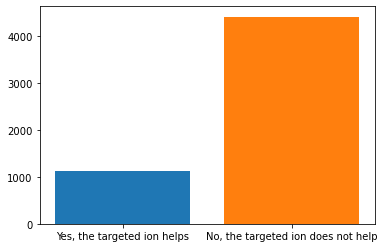

In [18]:
import matplotlib.pyplot as plt
plt.bar('Yes, the targeted ion helps', len(yes))
plt.bar('No, the targeted ion does not help', len(no))
plt.show()